In [3]:
# !pip install pyspark
# !pip install -U -q PyDrive
# !apt install openjdk-8-jdk-headless -qq
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [1]:
import itertools
from pyspark import SparkContext, SparkConf
from pyspark.sql import *
#from pyspark.sql.functions import * it overrides abs if we do it like that
import re, sys, pickle
from functools import reduce
import pyspark.sql.functions as F
import matplotlib.pyplot as pl

In [2]:
# create the Spark Session
spark = SparkSession.builder.getOrCreate()

# create the Spark Context
sc = spark.sparkContext

/home/ljj0512/.local/lib/python3.6/site-packages/pyspark/context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


In [36]:
#Euclidian
def l22(u, v):
    delta = [i-j for i,j in zip(u, v)]
    return reduce(lambda a, b: a + b * b, delta, 0)
    
#Manhattan
def l1(u, v):
    delta = [i-j for i,j in zip(u, v)]
    return reduce(lambda a, b: a + abs(b), delta, 0)

def findCentroid(pt, cens, distFcn, phi):
    best = float('inf')
    besti = None
    for i, cen in enumerate(cens.value):
        cand = distFcn(pt, cen)
        if cand < best:
            best = cand
            besti = i
    phi += best
    return besti, pt

def aggregate_UV(cumulative, pt):
    cumulative_pt, cumulative_cnt = cumulative
    for i in range(len(pt)):
        cumulative_pt[i] += pt[i]
    return cumulative_pt, cumulative_cnt + 1

def aggregate_UU(a, b):
    a_pt, a_cnt = a
    b_pt, b_cnt = b
    for i in range(len(a_pt)):
        a_pt[i] += b_pt[i]
    return a_pt, a_cnt + b_cnt

In [43]:
dataFile = "data.txt"
censFile = 'c1.txt' 
# censFile = 'c2.txt'
distFcn = l1 #Manhattan
# distFcn = l22 #Euclidian
outFile = 'dist_' + distFcn.__name__ + '__' + censFile

MAX_ITER = 20 #max iterations
k = 10 #clusters
NDATA = 4601
NDIM = 58
cens = []


# init centroids - py way :D
cens = []
with open(censFile) as fh:
    for line in fh:
        if not line:
            continue
        cens.append(list(map(float, line.split())))

cens = sc.broadcast(cens)

# load data
data = sc.textFile(dataFile)
data = data.map(lambda l: list(map(float, l.split())))

phi = sc.accumulator(0)
totCosts = []

for it in range(1, MAX_ITER + 1):
    print('\n' * 6 + 'iteration %d' % it + '\n' * 6)

    i_pt = data.map(lambda pt: findCentroid(pt, cens, distFcn, phi))
    
    # M: calc new centroid
    i_sumCoors_cnt = i_pt.aggregateByKey(([0] * NDIM, 0),
                                         aggregate_UV, aggregate_UU)
    i_sumCoors_cnt = i_sumCoors_cnt.collect()
    newCens = [None] * k
    for i, sumCoors_cnt in i_sumCoors_cnt:
        sumCoors, cnt = sumCoors_cnt
        newCens[i] = [sumCoors[j] / cnt for j in range(len(sumCoors))]
    assert not any([cen is None for cen in newCens])

    # record cost, prep new iter
    totCosts.append(phi.value)
    phi.value = 0
    cens.unpersist()
    cens = sc.broadcast(newCens)

print('\n' * 6 + '%f\n' * MAX_ITER % tuple(totCosts) + '\n' * 6 )
with open(outFile, 'wb') as fh:
    pickle.dump(totCosts, fh)







iteration 1












iteration 2












iteration 3












iteration 4












iteration 5












iteration 6












iteration 7












iteration 8












iteration 9












iteration 10












iteration 11












iteration 12












iteration 13












iteration 14












iteration 15












iteration 16












iteration 17












iteration 18












iteration 19












iteration 20












550117.142000
464869.275879
470897.382277
483914.409173
489216.071003
487629.668550
483711.923214
475330.773493
474871.238846
457232.920115
447494.386197
450915.012577
451250.367073
451974.595540
451570.364070
452739.011366
453082.730287
450583.670860
450368.749317
449011.363726









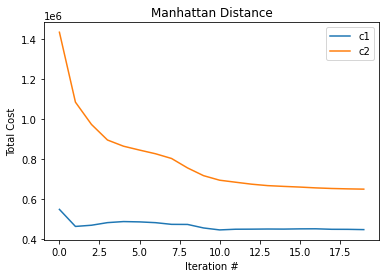

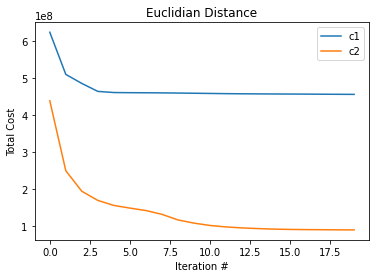

Euclidian c1 0.2648391714456053
Euclidian c2 0.7669795594605946
Manhattan c1 0.18654709691385904
Manhattan c2 0.5152079304669389


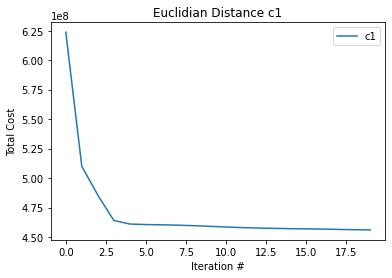

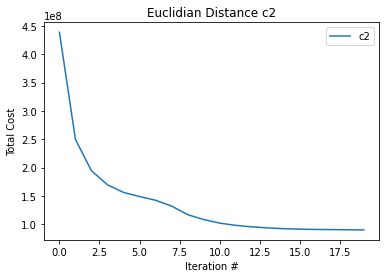

In [48]:
pl.close('all')

with open('dist_l1__c1.txt', 'rb') as fh:
    l1c1 = pickle.load(fh)
with open('dist_l1__c2.txt', 'rb') as fh:
    l1c2 = pickle.load(fh)
with open('dist_l22__c1.txt', 'rb') as fh:
    l22c1 = pickle.load(fh)
with open('dist_l22__c2.txt', 'rb') as fh:
    l22c2 = pickle.load(fh)

pl.title("Manhattan Distance")
pl.plot(l1c1, label='c1')
pl.plot(l1c2, label='c2')
pl.xlabel("Iteration #")
pl.ylabel("Total Cost")
pl.legend()
pl.savefig('plotManhattan.png', dpi=300, bbox_inches='tight')
pl.show()

pl.title("Euclidian Distance")
pl.plot(l22c1, label='c1')
pl.plot(l22c2, label='c2')
pl.xlabel("Iteration #")
pl.ylabel("Total Cost")
pl.legend()
pl.savefig('plotEuclidian.png', dpi=300, bbox_inches='tight')
pl.show()

pl.figure()
pl.title("Euclidian Distance c1")
pl.plot(l22c1, label='c1')
pl.xlabel("Iteration #")
pl.ylabel("Total Cost")
pl.legend()
pl.savefig('plotEuclidianC1.png', dpi=300, bbox_inches='tight')
pl.figure()
pl.title("Euclidian Distance c2")
pl.plot(l22c2, label='c2')
pl.xlabel("Iteration #")
pl.ylabel("Total Cost")
pl.legend()
pl.savefig('plotEuclidianC2.png', dpi=300, bbox_inches='tight')


def change(L):
    return (L[0] - L[10]) / L[0]

print('Euclidian c1', change(l22c1))
print('Euclidian c2', change(l22c2))
print('Manhattan c1', change(l1c1))
print('Manhattan c2', change(l1c2))

Euclidian c1 0.2648391714456053
Euclidian c2 0.7669795594605946
Manhattan c1 0.18654709691385904
Manhattan c2 0.5152079304669389


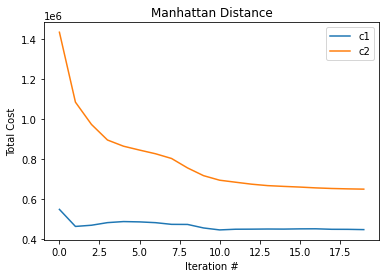

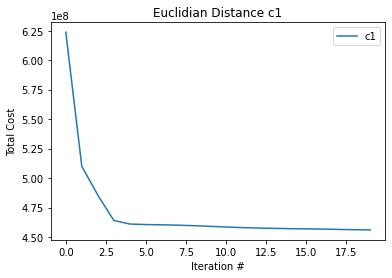

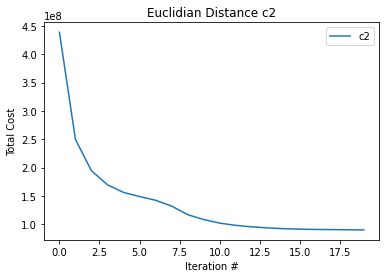

In [45]:
pl.close('all')

with open('dist_l1__c1.txt', 'rb') as fh:
    l1c1 = pickle.load(fh)
with open('dist_l1__c2.txt', 'rb') as fh:
    l1c2 = pickle.load(fh)
with open('dist_l22__c1.txt', 'rb') as fh:
    l22c1 = pickle.load(fh)
with open('dist_l22__c2.txt', 'rb') as fh:
    l22c2 = pickle.load(fh)

pl.title("Manhattan Distance")
pl.plot(l1c1, label='c1')
pl.plot(l1c2, label='c2')
pl.xlabel("Iteration #")
pl.ylabel("Total Cost")
pl.legend()
pl.savefig('plotManhattan.png', dpi=300, bbox_inches='tight')

pl.figure()
pl.title("Euclidian Distance c1")
pl.plot(l22c1, label='c1')
pl.xlabel("Iteration #")
pl.ylabel("Total Cost")
pl.legend()
pl.savefig('plotEuclidianC1.png', dpi=300, bbox_inches='tight')
pl.figure()
pl.title("Euclidian Distance c2")
pl.plot(l22c2, label='c2')
pl.xlabel("Iteration #")
pl.ylabel("Total Cost")
pl.legend()
pl.savefig('plotEuclidianC2.png', dpi=300, bbox_inches='tight')


def change(L):
    return (L[0] - L[10]) / L[0]

print('Euclidian c1', change(l22c1))
print('Euclidian c2', change(l22c2))
print('Manhattan c1', change(l1c1))
print('Manhattan c2', change(l1c2))

In [15]:
x = np.array([1,2,4])
y = np.array([2,3,4])
print(x-y)

[-1 -1  0]


In [33]:
import numpy as np
from itertools import combinations
cens = []
file = "c1.txt"
with open(file) as f:
    for data in f:
        cens.append(list(map(float, data.split(" "))))
cens = np.array(cens)
totalsum = 0
for i, j in combinations(range(10), 2):
    totalsum += ((cens[i]-cens[j])**2).sum()
print(totalsum)

49623174.615875006


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from scipy.linalg import svd, eigh
cens = []
file = "c1.txt"
with open(file) as f:
    for data in f:
        cens.append(list(map(float, data.split(" "))))
cens = np.array(cens).T

pca = PCA(n_components=2, random_state=1004)
iris_pca = pca.fit_transform(cens)
iris_pca[:10]


# ## Visualization

# ## target
# data['target'][:5]
# # array([0, 0, 0, 0, 0])


# ## mapping target name using numpy vectorization
# species_map_dict = {
#     0: 'setosa', 
#     1: 'versicolor', 
#     2: 'virginica'
# }

# iris_pca_df = pd.DataFrame({
#     'pc_1': iris_pca[:, 0], 
#     'pc_2': iris_pca[:, 1], 
#     'species': np.vectorize(species_map_dict.get)(data['target']) # numpy broadcasting
# })


# iris_pca_df.head()

# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.rcParams['figure.figsize'] = (7, 7)
# sns.scatterplot(
#     x='pc_1', 
#     y='pc_2',
#     hue='species', 
#     style='species',
#     s=100,
#     data=iris_pca_df
# )

# plt.title('PCA result of IRIS dataset')
# plt.xlabel('Principal Component 1', fontsize=14)
# plt.ylabel('Principal Component 2', fontsize=14)
# plt.show()

array([[-61.53398733,  -3.2837048 ],
       [-61.54676798,  -3.45158553],
       [-60.55366844,  -3.56866952],
       [-61.73452068,  -3.25412302],
       [-60.16323778,  -3.15120763],
       [-61.41054242,  -3.55495102],
       [-61.24614301,  -3.34088242],
       [-61.46844032,  -3.27260686],
       [-60.77441226,  -2.64869234],
       [-60.77282618,  -3.25357102]])

In [34]:
import numpy as np
from itertools import combinations
cens = []
file = "c2.txt"
with open(file) as f:
    for data in f:
        cens.append(list(map(float, data.split(" "))))
cens = np.array(cens)
totalsum = 0
for i, j in combinations(range(10), 2):
    totalsum += ((cens[i]-cens[j])**2).sum()
print(totalsum)

2953317860.426528


In [4]:
from functools import reduce
tup = (2,1,0,2)
for i in range(8):
    print(reduce(lambda x, y: x+y, tup, i))

5
6
7
8
9
10
11
12
